In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import nibabel
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from nilearn.plotting import find_xyz_cut_coords
from glob import glob
from scipy.stats.stats import pearsonr
from nilearn.image import mean_img
from matplotlib import pyplot as plt

In [3]:
db= pd.read_csv("../data/database.csv")
db.head()

Unnamed: 0                     stim  \
0           0  left-right_button_press   
1           1  left-right_button_press   
2           2  left-right_button_press   
3           3  left-right_button_press   
4           4  left-right_button_press   

                                                path  subject            task  
0  /storage/store/data/ibc/smooth_derivatives/sub...        1  archi_standard  
1  /storage/store/data/ibc/smooth_derivatives/sub...        2  archi_standard  
2  /storage/store/data/ibc/smooth_derivatives/sub...        4  archi_standard  
3  /storage/store/data/ibc/smooth_derivatives/sub...        5  archi_standard  
4  /storage/store/data/ibc/smooth_derivatives/sub...        6  archi_standard

In [4]:
mask_path = "/storage/store/data/ibc/derivatives/group/gm_mask.nii.gz"
masker_3d = NiftiMasker(
        mask_img=mask_path
        ).fit()

In [5]:
def extract_original_path(db, subject, stim):
    subjects_list = [ 1,  2,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14]
    i_subject = subjects_list[int(subject)]
    db_subject = db[db["subject"] == i_subject]
    original_path = db_subject[db_subject["stim"] == stim]["path"].values[0]
    return original_path
    
def extract_info(path):
    p = path.split("exp11/")[1]
    subject = p.split("subject")[1].split("_stim")[0]
    stim = p.split("_stim_")[1].split("__")[0]
    task = p.split("__")[1].split("_exp")[0]
    algo = p.split("algo")[1].split("subject")[0]
    name = p.split("_algo")[0]
    
    return name, subject, stim, task, algo 

print extract_info("/storage/workspace/hrichard/results/exp11/ibcpredict_algohyperalignmentsubject6_stim_left-right_button_press__archi_standard_exp11.nii")
print extract_original_path(db, "6", "left-right_button_press")

('ibcpredict', '6', 'left-right_button_press', 'archi_standard', 'hyperalignment')
/storage/store/data/ibc/smooth_derivatives/sub-08/ses-01/res_stats_archi_standard_ffx/stat_maps/left-right_button_press.nii.gz


In [6]:
def sort(s_list, info_id=[0, 1, 2, 3, 4]):
    name_list = []
    for s in s_list:
        info = extract_info(s)
        info_list = [info[int(i)] for i in info_id]
        name_list.append("_".join(info_list))
    return np.array(s_list)[np.argsort(name_list)]

# name, subject, stim, task, algo 

nb_subject = 0
algo_prec= ""
sort(glob("/storage/workspace/hrichard/results/exp11/ibcpredict*subject*horizontal*"), info_id=[0, 2, 3, 4, 1])

array([ '/storage/workspace/hrichard/results/exp11/ibcpredict_algoRH_1e5subject0_stim_horizontal-vertical__archi_standard_exp11.nii',
       '/storage/workspace/hrichard/results/exp11/ibcpredict_algoRH_1e5subject1_stim_horizontal-vertical__archi_standard_exp11.nii',
       '/storage/workspace/hrichard/results/exp11/ibcpredict_algoRH_1e5subject10_stim_horizontal-vertical__archi_standard_exp11.nii',
       '/storage/workspace/hrichard/results/exp11/ibcpredict_algoRH_1e5subject11_stim_horizontal-vertical__archi_standard_exp11.nii',
       '/storage/workspace/hrichard/results/exp11/ibcpredict_algoRH_1e5subject2_stim_horizontal-vertical__archi_standard_exp11.nii',
       '/storage/workspace/hrichard/results/exp11/ibcpredict_algoRH_1e5subject3_stim_horizontal-vertical__archi_standard_exp11.nii',
       '/storage/workspace/hrichard/results/exp11/ibcpredict_algoRH_1e5subject4_stim_horizontal-vertical__archi_standard_exp11.nii',
       '/storage/workspace/hrichard/results/exp11/ibcpredict_algoR

('ibcpredict', '1', '2back-0back', 'hcp_wm', 'RRR_25_003')
(0.1047112019785626, 0.0)
('ibcpredict', '1', '2back-0back', 'hcp_wm', 'hyperalignment')
(0.065198687215485204, 0.0)
('ibcpredict', '1', '2back-0back', 'hcp_wm', 'mean')
(0.14448936742730381, 0.0)
('ibcpredict', '1', '2back-0back', 'hcp_wm', 'ridgeCV_1500_2000_2500')
(0.078862237033372695, 0.0)


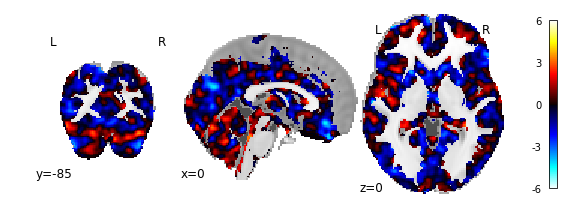

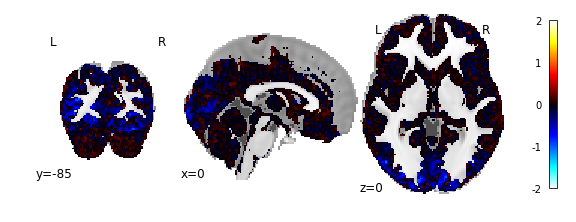

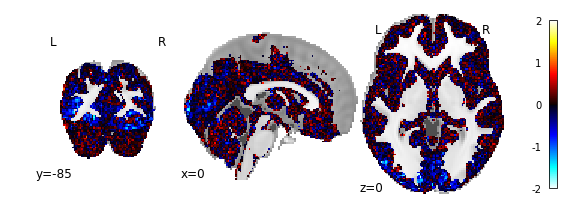

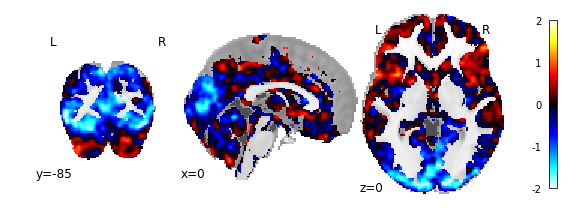

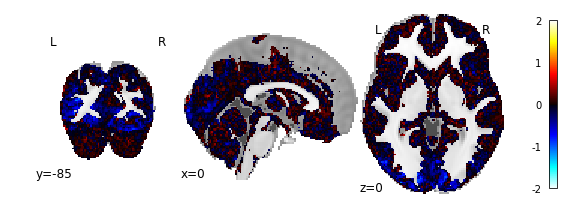

In [58]:
seen = set()
pearson_score = []
for path in sort(glob("/storage/workspace/hrichard/results/exp11/ibcpredict*algo[mrRh][ieyR]*subject[1]_*2back*")):
    info = extract_info(path)
    print(info)
    name = "_".join(info)
    original_path = extract_original_path(db, info[1], info[2])
    if info[1] + info[2] not in seen:
        seen.add(info[1] + info[2])
        original_X = masker_3d.transform(original_path)
        original_img = masker_3d.inverse_transform(original_X)
        cut_xyz = [0, -85, 0]
        plotting.plot_stat_map(original_img,
            cut_coords=cut_xyz,
            draw_cross=False,
            vmax=6
            )
        
    X = masker_3d.transform(path)
    img = masker_3d.inverse_transform(X)
    
    print(pearsonr(original_X.flatten(), X.flatten()))
    pearson_score.append(pearsonr(original_X.flatten(), X.flatten())[0])
    
    plotting.plot_stat_map(
    img,
    cut_coords=cut_xyz,
    draw_cross=False,
    vmax=2
    )

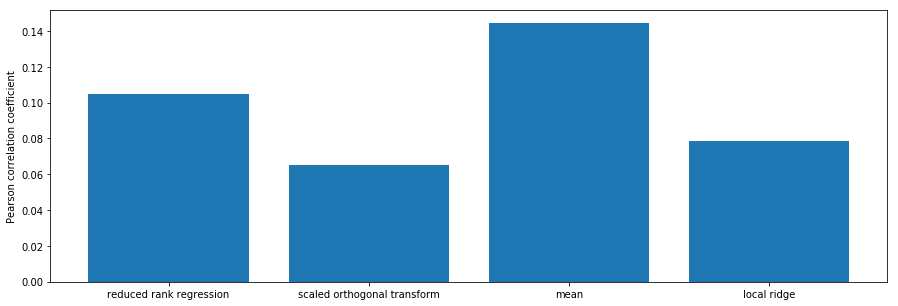

In [59]:
score = np.array(pearson_score)
plt.figure(figsize=(15,5))
plt.bar([1, 2, 3, 4], score, tick_label=["reduced rank regression", "scaled orthogonal transform", "mean", "local ridge"])
plt.ylabel("Pearson correlation coefficient")

('ibcpredict', '5', 'horizontal-vertical', 'archi_standard', 'RRR_25_003')
(0.25190124040326761, 0.0)
('ibcpredict', '5', 'horizontal-vertical', 'archi_standard', 'hyperalignment')
(0.13392122899396713, 0.0)
('ibcpredict', '5', 'horizontal-vertical', 'archi_standard', 'mean')
(0.1322961284694871, 0.0)
('ibcpredict', '5', 'horizontal-vertical', 'archi_standard', 'ridgeCV_1500_2000_2500')
(0.21565825208971123, 0.0)


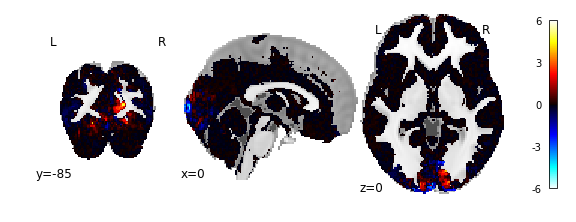

In [51]:
seen = set()
pearson_score = []
for path in sort(glob("/storage/workspace/hrichard/results/exp11/ibcpredict*algo[mrRh][ieyR]*subject[5]_*horizontal-vertical*")):
    info = extract_info(path)
    print(info)
    name = "_".join(info)
    original_path = extract_original_path(db, info[1], info[2])
    if info[1] + info[2] not in seen:
        seen.add(info[1] + info[2])
        original_X = masker_3d.transform(original_path)
        original_img = masker_3d.inverse_transform(original_X)
        cut_xyz = [0, -85, 0]
        plotting.plot_stat_map(original_img,
            cut_coords=cut_xyz,
            draw_cross=False,
            vmax=15
            )
        
    X = masker_3d.transform(path)
    img = masker_3d.inverse_transform(X)
    
    print(pearsonr(original_X.flatten(), X.flatten()))
    pearson_score.append(pearsonr(original_X.flatten(), X.flatten())[0])
    plotting.plot_stat_map(
    img,
    cut_coords=cut_xyz,
    draw_cross=False,
    vmax=6
    )

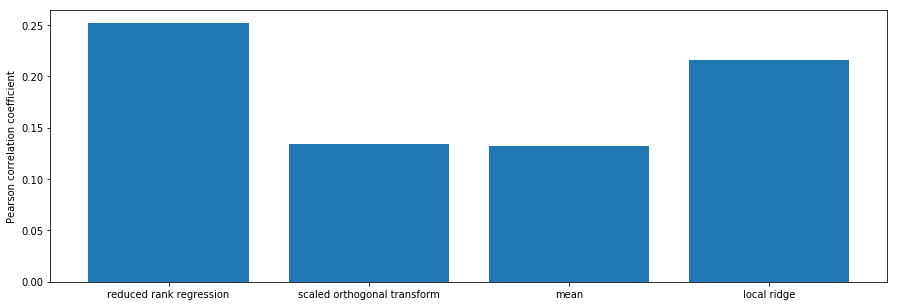

In [50]:
score = np.array(pearson_score)
plt.figure(figsize=(15,5))
plt.bar([1, 2, 3, 4], score, tick_label=["reduced rank regression", "scaled orthogonal transform", "mean", "local ridge"])
plt.ylabel("Pearson correlation coefficient")

In [ ]:
corr_coef = {}
paths = sort(glob("/storage/workspace/hrichard/results/exp11/ibcpredict*subject[01235689][1_]*"), info_id = [0, 2, 3, 4, 1])
print(paths)

i=0
name, subject, stim, task, algo  = extract_info(paths[0])
seen = algo
temp_list = []
res_list = []
for path in paths:
    i+=1
    img = nibabel.load(path)
    X = img.get_data()
    name, subject, stim, task, algo  = extract_info(path)
    original_path = extract_original_path(db, subject, stim)
    original_X = masker_3d.inverse_transform(masker_3d.transform(original_path)).get_data()
    
    if algo != seen: 
        print(prec_stim + ": " + seen + ": " + str(np.array(temp_list).mean()) + " - n_exp: " + str(len(temp_list)))
        res_list.append((prec_stim, seen, np.array(temp_list).mean()))
        temp_list = [pearsonr(original_X.flatten(), X.flatten())[0]]
        seen = algo
    else:
        temp_list.append(pearsonr(original_X.flatten(), X.flatten())[0])
    
    prec_stim = stim + "__" + task

In [31]:
res_list.append((prec_stim, seen, np.array(temp_list).mean()))

In [45]:
res_dict = {}
for res in res_list:
    if type(res) != np.float64:
        stim, algo, score = res
        if algo in res_dict:
            res_dict[algo].append(score)
        else:
            res_dict[algo] = []

In [50]:
values = []
for algo, list_algo in res_dict.items():
    print(algo, np.array(list_algo).mean())
    values.append(np.array(list_algo).mean())

values

('ridgeCV_1500_2000_2500', 0.1434319225277968)
('RH_1e6', 0.1257215968831388)
('RH_1e5', 0.12428222117321469)
('hyperalignment', 0.10680684461742258)
('RRR_25_003', 0.17426670022792576)
('mean', 0.33207308266690427)


[0.1434319225277968,
 0.1257215968831388,
 0.12428222117321469,
 0.10680684461742258,
 0.17426670022792576,
 0.33207308266690427]

In [28]:
print(prec_stim + ": " + seen + ": " + str(np.array(temp_list).mean()) + " - n_exp: " + str(len(temp_list)))

word-pseudo__language_nsp: ridgeCV_1500_2000_2500: 0.0507494718478 - n_exp: 9


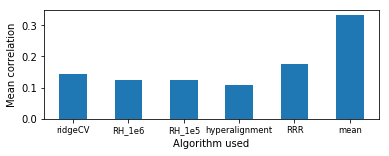

In [57]:
import matplotlib.pyplot as plt
names = ["ridgeCV", "RH_1e6", "RH_1e5", "hyperalignment", "RRR", "mean"]
values = [0.1434319225277968,
 0.1257215968831388,
 0.12428222117321469,
 0.10680684461742258,
 0.17426670022792576,
 0.33207308266690427]

plt.figure(figsize=(6,2))
plt.bar(np.array(range(len(values)))*1000, values, width=500, align='center')
plt.xticks(np.array(range(len(values)))*1000, names, size='small')
plt.ylabel("Mean correlation")
plt.xlabel("Algorithm used")
plt.legend()